<a href="https://www.kaggle.com/code/pjbhaumik/jpx-lstm-autoencoder-lstm-pipeline?scriptVersionId=94292137" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


# Hypothesis: Each investment is a time series. We cannot train a model for each investment, so we should attempt to cluster. We can use LSTM autoencoders to do this.
1. Visualize rank as a function of time for a few investments
2. Develop an LSTM autoencoder class 
3. For each investment, run the first encoder... if the reconstruction error is high, then instantiate and train a new autoencoder.
4. After a max of 50 autoencoders, then assign remaining investments to the autoencoder with the least reconstruction error.
5. After all investments have been assigned to an autoencoder, then train an LSTM for each cluster. There will be 50 LSTMs. A dictionary will maintain a map between LSTM's and investments.
6. During inference, use the investment ID to map to the right LSTM and then predict the rank

In [2]:
df = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv')
print(df.head())
print(df.info(verbose = True))
print(df.describe())

           RowId        Date  SecuritiesCode    Open    High     Low   Close  \
0  20170104_1301  2017-01-04            1301  2734.0  2755.0  2730.0  2742.0   
1  20170104_1332  2017-01-04            1332   568.0   576.0   563.0   571.0   
2  20170104_1333  2017-01-04            1333  3150.0  3210.0  3140.0  3210.0   
3  20170104_1376  2017-01-04            1376  1510.0  1550.0  1510.0  1550.0   
4  20170104_1377  2017-01-04            1377  3270.0  3350.0  3270.0  3330.0   

    Volume  AdjustmentFactor  ExpectedDividend  SupervisionFlag    Target  
0    31400               1.0               NaN            False  0.000730  
1  2798500               1.0               NaN            False  0.012324  
2   270800               1.0               NaN            False  0.006154  
3    11300               1.0               NaN            False  0.011053  
4   150800               1.0               NaN            False  0.003026  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entri

# Visualize Rank as a Function of Time for a Few Investments

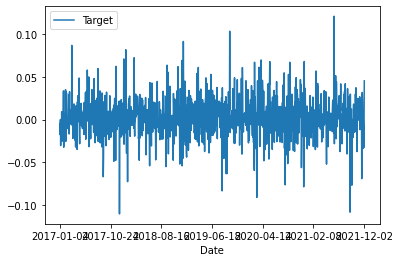

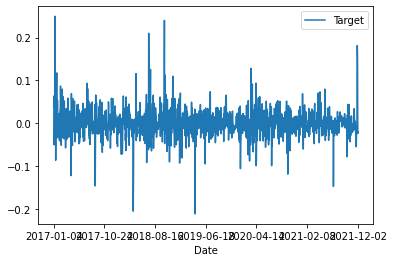

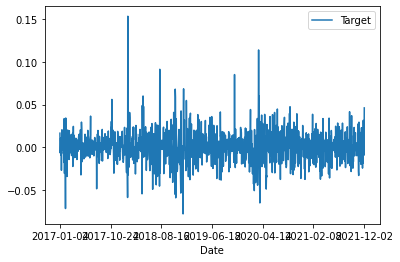

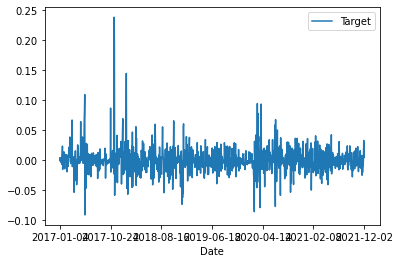

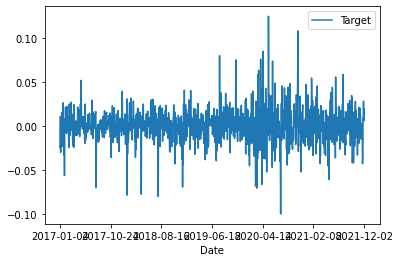

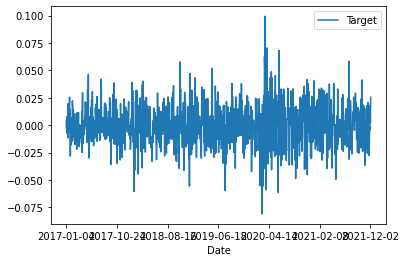

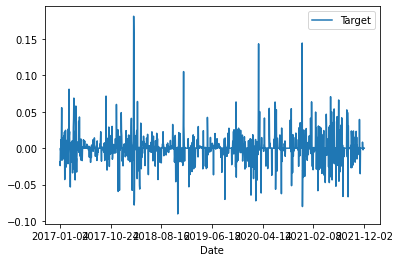

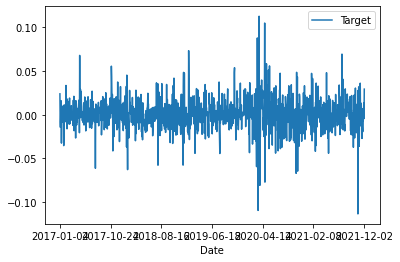

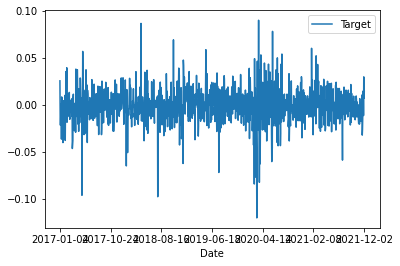

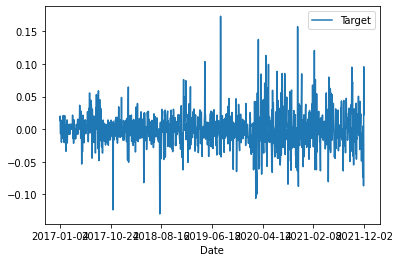

In [3]:
for i in range(10):
    df[df['SecuritiesCode'] == df['SecuritiesCode'].sample().iloc[0]].plot('Date', 'Target')

# Develop an LSTM AutoEncoder Class

In [4]:
# Based on Chitta Ranjan's example and text available here: https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
# lstm autoencoder to recreate a timeseries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import BatchNormalization
from keras.layers import MaxPooling1D
from keras.layers import AveragePooling1D
'''
A UDF to convert input data into 3-D
array as required for LSTM network.
'''

def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [5]:
# define input timeseries
timeseries = np.array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                       [0.1**3, 0.2**3, 0.3**3, 0.4**3, 0.5**3, 0.6**3, 0.7**3, 0.8**3, 0.9**3]]).transpose()

timesteps = timeseries.shape[0]
n_features = timeseries.shape[1]
timeseries

array([[0.1  , 0.001],
       [0.2  , 0.008],
       [0.3  , 0.027],
       [0.4  , 0.064],
       [0.5  , 0.125],
       [0.6  , 0.216],
       [0.7  , 0.343],
       [0.8  , 0.512],
       [0.9  , 0.729]])

In [6]:
timesteps = 3
X, y = temporalize(X = timeseries, y = np.zeros(len(timeseries)), lookback = timesteps)

n_features = 2
X = np.array(X)
X = X.reshape(X.shape[0], timesteps, n_features)

X

array([[[0.3  , 0.027],
        [0.4  , 0.064],
        [0.5  , 0.125]],

       [[0.4  , 0.064],
        [0.5  , 0.125],
        [0.6  , 0.216]],

       [[0.5  , 0.125],
        [0.6  , 0.216],
        [0.7  , 0.343]],

       [[0.6  , 0.216],
        [0.7  , 0.343],
        [0.8  , 0.512]],

       [[0.7  , 0.343],
        [0.8  , 0.512],
        [0.9  , 0.729]]])

In [7]:
# define model

#encoder
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
model.add(AveragePooling1D())
model.add(LSTM(64, activation='relu', return_sequences=False))

#decoder
model.add(RepeatVector(timesteps))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
model.summary()

2022-04-29 04:25:27.431332: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 128)            67072     
_________________________________________________________________
average_pooling1d (AveragePo (None, 1, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 3, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 3, 128)            98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 3, 2)              2

In [8]:
# fit model
model.fit(X, X, epochs=300, batch_size=5, verbose=0)
# demonstrate reconstruction
yhat = model.predict(X, verbose=0)
print('---Predicted---')
print(np.round(yhat,3))
print('---Actual---')
print(np.round(X, 3))

2022-04-29 04:25:27.976691: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


---Predicted---
[[[0.328 0.048]
  [0.43  0.074]
  [0.49  0.125]]

 [[0.392 0.07 ]
  [0.506 0.125]
  [0.584 0.214]]

 [[0.479 0.117]
  [0.605 0.215]
  [0.7   0.347]]

 [[0.585 0.197]
  [0.703 0.338]
  [0.813 0.516]]

 [[0.71  0.357]
  [0.796 0.512]
  [0.901 0.731]]]
---Actual---
[[[0.3   0.027]
  [0.4   0.064]
  [0.5   0.125]]

 [[0.4   0.064]
  [0.5   0.125]
  [0.6   0.216]]

 [[0.5   0.125]
  [0.6   0.216]
  [0.7   0.343]]

 [[0.6   0.216]
  [0.7   0.343]
  [0.8   0.512]]

 [[0.7   0.343]
  [0.8   0.512]
  [0.9   0.729]]]


In [9]:
np.mean(yhat - X)

0.00159532691538334